161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


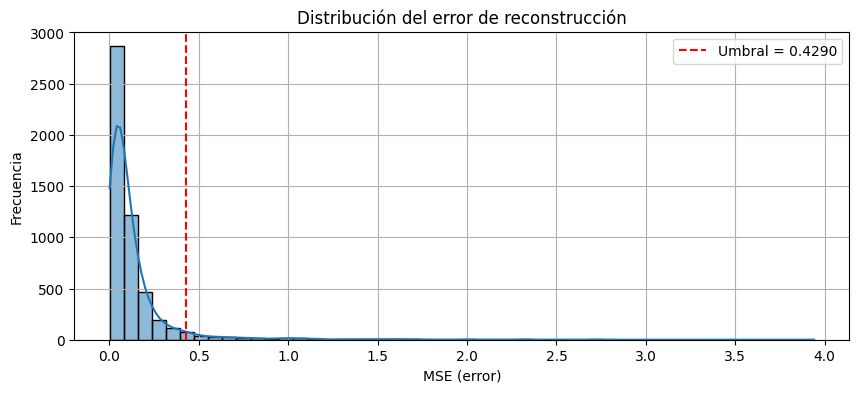

🔍 Matriz de confusión:
[[4866  134]
 [  26  124]]

📈 Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9947    0.9732    0.9838      5000
           1     0.4806    0.8267    0.6078       150

    accuracy                         0.9689      5150
   macro avg     0.7377    0.8999    0.7958      5150
weighted avg     0.9797    0.9689    0.9729      5150



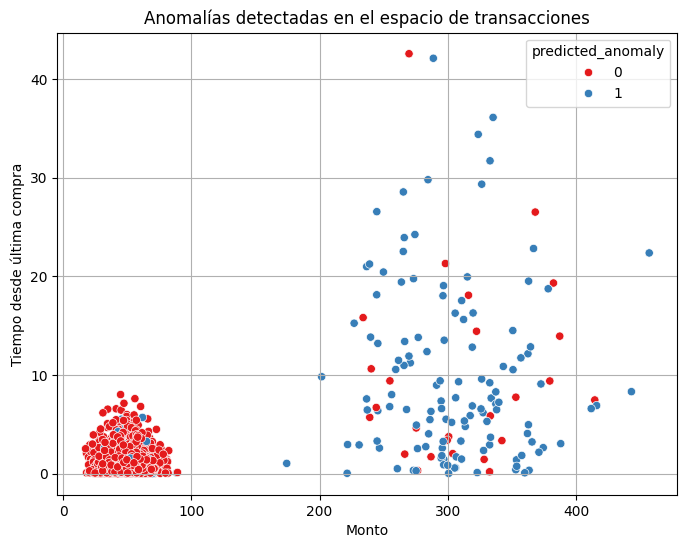

In [1]:
# ✅ Instalar dependencias si hace falta
!pip install -q tensorflow scikit-learn

# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# ======================================
# 1️⃣ Simular dataset de transacciones
# ======================================
np.random.seed(42)

# Transacciones normales
n_normal = 5000
normal_data = pd.DataFrame({
    'amount': np.random.normal(50, 10, n_normal),
    'time_since_last': np.random.exponential(1.0, n_normal),
    'num_products': np.random.poisson(2, n_normal),
    'discount': np.random.beta(2, 5, n_normal) * 0.3,
    'channel': np.random.choice([0, 1, 2], size=n_normal, p=[0.5, 0.3, 0.2])
})

# Transacciones anómalas
n_anomalies = 150
anomaly_data = pd.DataFrame({
    'amount': np.random.normal(300, 50, n_anomalies),
    'time_since_last': np.random.exponential(10.0, n_anomalies),
    'num_products': np.random.poisson(10, n_anomalies),
    'discount': np.random.uniform(0.4, 0.9, n_anomalies),
    'channel': np.random.choice([0, 1, 2], size=n_anomalies)
})

# Etiquetas
normal_data['is_anomaly'] = 0
anomaly_data['is_anomaly'] = 1

df = pd.concat([normal_data, anomaly_data], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

# ======================================
# 2️⃣ Preprocesamiento
# ======================================
features = ['amount', 'time_since_last', 'num_products', 'discount', 'channel']
X = df[features].copy()
y_true = df['is_anomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

# ======================================
# 3️⃣ Construcción del Autoencoder
# ======================================
input_dim = X_train.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# ======================================
# 4️⃣ Entrenamiento
# ======================================
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=0
)

# ======================================
# 5️⃣ Evaluación: reconstrucción y umbral
# ======================================
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

threshold = np.percentile(mse, 95)  # umbral automático (top 5% más altos)
df['reconstruction_error'] = mse
df['predicted_anomaly'] = (mse > threshold).astype(int)

# ======================================
# 6️⃣ Visualización
# ======================================
# Error de reconstrucción
plt.figure(figsize=(10, 4))
sns.histplot(df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Umbral = {threshold:.4f}')
plt.title("Distribución del error de reconstrucción")
plt.xlabel("MSE (error)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

# Matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, df['predicted_anomaly'])
print("🔍 Matriz de confusión:")
print(cm)

print("\n📈 Reporte de clasificación:")
print(classification_report(y_true, df['predicted_anomaly'], digits=4))

# Visualizar puntos anomalía
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['amount'], y=df['time_since_last'], hue=df['predicted_anomaly'], palette='Set1')
plt.title("Anomalías detectadas en el espacio de transacciones")
plt.xlabel("Monto")
plt.ylabel("Tiempo desde última compra")
plt.grid(True)
plt.show()


🚨 Top 10 transacciones más anómalas:


,amount,time_since_last,num_products,discount,channel,reconstruction_error,predicted_anomaly,is_anomaly
711,457.067309,22.382856,8,0.505893,2,3.941300,1,1
3552,332.947634,31.723569,14,0.423890,0,3.690652,1,1
2671,286.879593,6.319109,19,0.492781,1,3.451290,1,1
1408,174.417795,1.047642,14,0.425102,2,3.268686,1,1
135,388.061289,3.049796,6,0.422269,1,2.771121,1,1
1877,443.186616,8.320747,7,0.740938,2,2.754608,1,1
3052,295.175848,6.605839,18,0.599434,0,2.751561,1,1
3882,335.324371,36.123908,11,0.431845,2,2.695427,1,1
722,325.920355,6.572534,5,0.820814,0,2.581181,1,1
1023,416.033408,6.910799,12,0.418758,1,2.470968,1,1


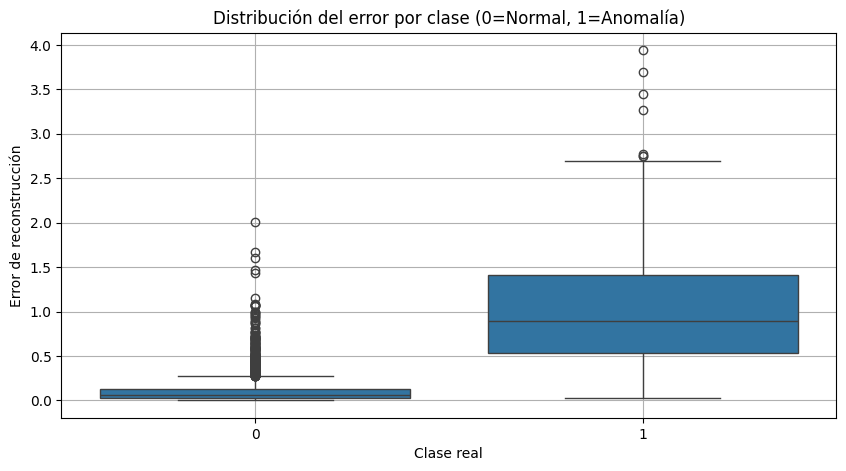

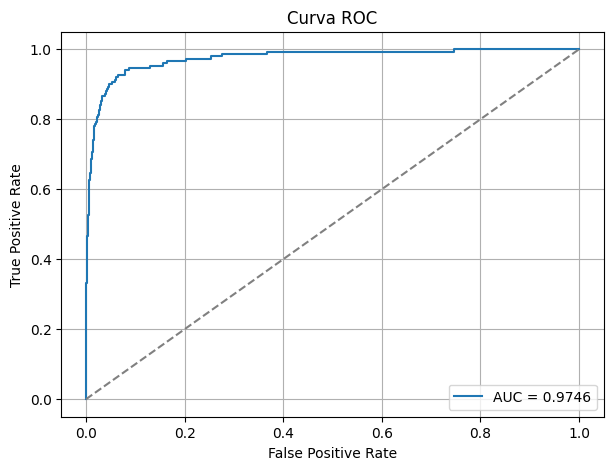

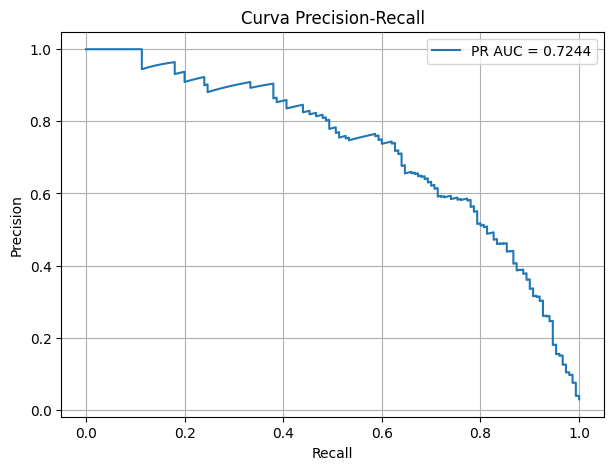

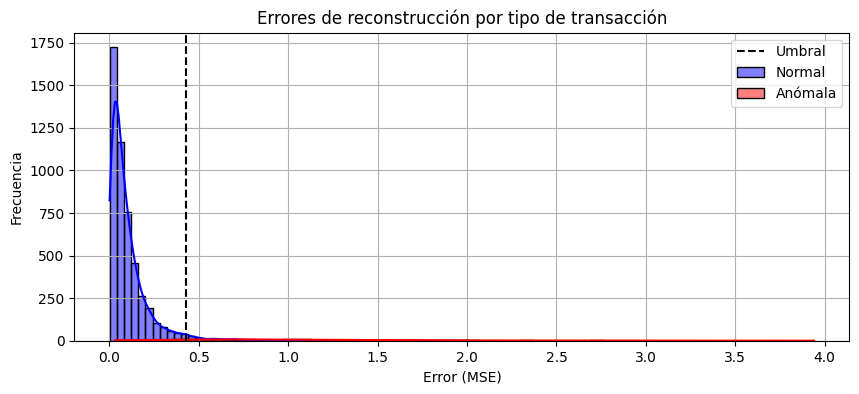

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

# 1️⃣ Mostrar las 10 transacciones más anómalas
top_anomalies = df.sort_values('reconstruction_error', ascending=False).head(10)
print("🚨 Top 10 transacciones más anómalas:")
display(top_anomalies[features + ['reconstruction_error', 'predicted_anomaly', 'is_anomaly']])

# 2️⃣ Visualización comparativa
plt.figure(figsize=(10, 5))
sns.boxplot(x='is_anomaly', y='reconstruction_error', data=df)
plt.title("Distribución del error por clase (0=Normal, 1=Anomalía)")
plt.xlabel("Clase real")
plt.ylabel("Error de reconstrucción")
plt.grid(True)
plt.show()

# 3️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_true, df['reconstruction_error'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 4️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, df['reconstruction_error'])
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# 5️⃣ Histograma comparativo de errores
plt.figure(figsize=(10, 4))
sns.histplot(df[df['is_anomaly'] == 0]['reconstruction_error'], color='blue', label='Normal', bins=50, kde=True)
sns.histplot(df[df['is_anomaly'] == 1]['reconstruction_error'], color='red', label='Anómala', bins=50, kde=True)
plt.axvline(threshold, color='black', linestyle='--', label=f'Umbral')
plt.title("Errores de reconstrucción por tipo de transacción")
plt.xlabel("Error (MSE)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()
